#  CH4 over Delhi, India from Sentinel 5P

To explore other bands in Sentinel-5P data, you can modify the bands parameter in the load_collection function. Sentinel-5P provides several other bands, such as:

CO (Carbon Monoxide), SO2 (Sulfur Dioxide), O3 (Ozone), CH4 (Methane), HCHO (Formaldehyde), AER_AI (Aerosol Index)

In [13]:
import openeo

In [7]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [8]:
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [77.11, 28.69],
            [77.11, 28.56],
            [77.29, 28.56],
            [77.29, 28.69],
            [77.11, 28.69],
        ]
    ],
}

In [9]:
s5covid = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2020-06-01", "2021-06-30"],
    spatial_extent={"west": 77.11, "south": 28.56, "east": 77.29, "north": 28.69},
    bands=["CH4"],
)

In [10]:
# Now aggregate by day to avoid having multiple data per day
s5covid = s5covid.aggregate_temporal_period(reducer="mean", period="day")

# let's create a spatial aggregation to generate mean timeseries data
s5covid = s5covid.aggregate_spatial(reducer="mean", geometries=aoi)

In [11]:
# Create a datacube for period after COVID lockdowns

s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-06-01", "2023-06-30"],
    spatial_extent={"west": 77.11, "south": 28.56, "east": 77.29, "north": 28.69},
    bands=["CH4"],
)

# Now aggregate by day to avoid having multiple data per day
s5post = s5post.aggregate_temporal_period(reducer="mean", period="day")

# Now create a spatial aggregation to generate mean timeseries data
s5post = s5post.aggregate_spatial(reducer="mean", geometries=aoi)

In [12]:
job = s5covid.execute_batch(title="CH4 during Covid", outputfile="during_covid.nc")

0:00:00 Job 'j-24100379c10a425e91abd4b2c20ca5c3': send 'start'
0:00:14 Job 'j-24100379c10a425e91abd4b2c20ca5c3': created (progress 0%)
0:00:19 Job 'j-24100379c10a425e91abd4b2c20ca5c3': created (progress 0%)
0:00:26 Job 'j-24100379c10a425e91abd4b2c20ca5c3': created (progress 0%)
0:00:40 Job 'j-24100379c10a425e91abd4b2c20ca5c3': created (progress 0%)
0:00:50 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:01:03 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:01:18 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:01:37 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:02:10 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:02:40 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:03:23 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:04:10 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progress N/A)
0:05:10 Job 'j-24100379c10a425e91abd4b2c20ca5c3': running (progre

In [14]:
job = s5post.execute_batch(title="CH4 Post-Covid", outputfile="post_covid.nc")

0:00:00 Job 'j-2410038451554ab6ae9fa397b030b47f': send 'start'
0:00:23 Job 'j-2410038451554ab6ae9fa397b030b47f': created (progress 0%)
0:00:29 Job 'j-2410038451554ab6ae9fa397b030b47f': created (progress 0%)
0:00:40 Job 'j-2410038451554ab6ae9fa397b030b47f': created (progress 0%)
0:00:57 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:01:23 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:01:35 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:01:59 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:02:18 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:02:48 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:03:19 Job 'j-2410038451554ab6ae9fa397b030b47f': running (progress N/A)
0:04:14 Job 'j-2410038451554ab6ae9fa397b030b47f': finished (progress 100%)


In [15]:
import xarray as xr
import matplotlib.pyplot as plt

In [16]:
# load the results
duringdata = xr.load_dataset("during_covid.nc")
postdata = xr.load_dataset("post_covid.nc")

In [17]:
duringdata = duringdata.rolling(t=30).mean()
postdata = postdata.rolling(t=30).mean()

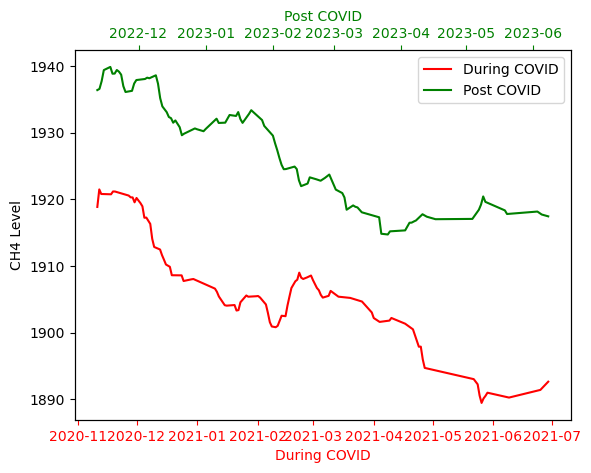

In [22]:
fig, ax1 = plt.subplots(dpi=100)
(line1,) = ax1.plot(
    duringdata.t, duringdata.CH4.to_numpy().flatten(), color="r", label="During COVID"
)
ax1.set_xlabel("During COVID")
ax1.set_ylabel("CH4 Level")
ax1.xaxis.label.set_color("r")
ax1.tick_params(axis="x", colors="r")

ax2 = ax1.twiny()
(line2,) = ax2.plot(
    postdata.t, postdata.CH4.to_numpy().flatten(), color="g", label="Post COVID"
)
ax2.set_xlabel("Post COVID")
# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="upper right")
ax2.xaxis.label.set_color("g")
ax2.tick_params(axis="x", colors="g")